In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import seaborn as sns
import os
os.chdir("/content/drive/MyDrive/study/RStanBook/")

In [7]:
df = pd.read_table('data/data-salary.txt', sep=',')
df.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


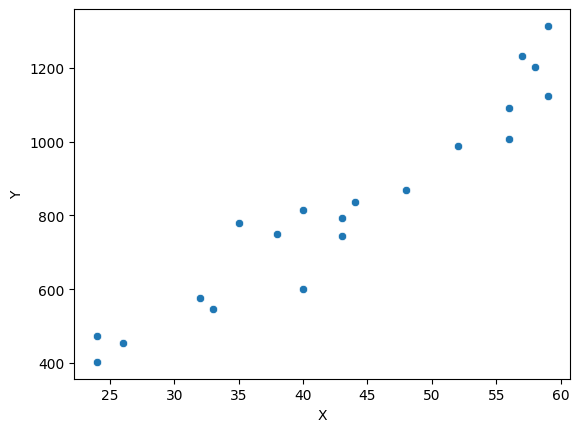

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(x=df["X"], y=df["Y"])
plt.show()

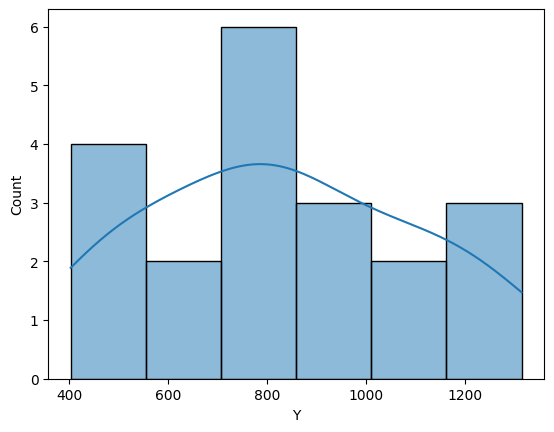

In [13]:
fig, ax = plt.subplots()
sns.histplot(df["Y"], kde=True)
plt.show()

In [15]:
import statsmodels.api as sm
Y = df['Y']
X = df['X']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           2.47e-11
Time:                        06:54:24   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -119.6971     68.148     -1.756      0.0

In [33]:
model1 = pm.Model()
Y = df['Y']
X = df['X']

with model1:
    # グラフィカルモデルにデータも入れてわかりやすくしたいので定義
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    a = pm.Normal("a", mu=0.0, sigma=100.0)
    b = pm.Normal("b", mu=0.0, sigma=100.0)

    mu = pm.Deterministic("mu", a*X_data+b)

    epsilon = pm.HalfNormal("epsilon", sigma=10.0)

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

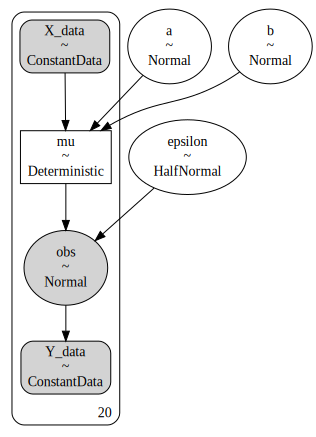

In [34]:
g = pm.model_to_graphviz(model1)
display(g)

In [46]:
with model1:
    idata1 = pm.sample(draws=1000, tune=1000, chains=4, random_seed=42)

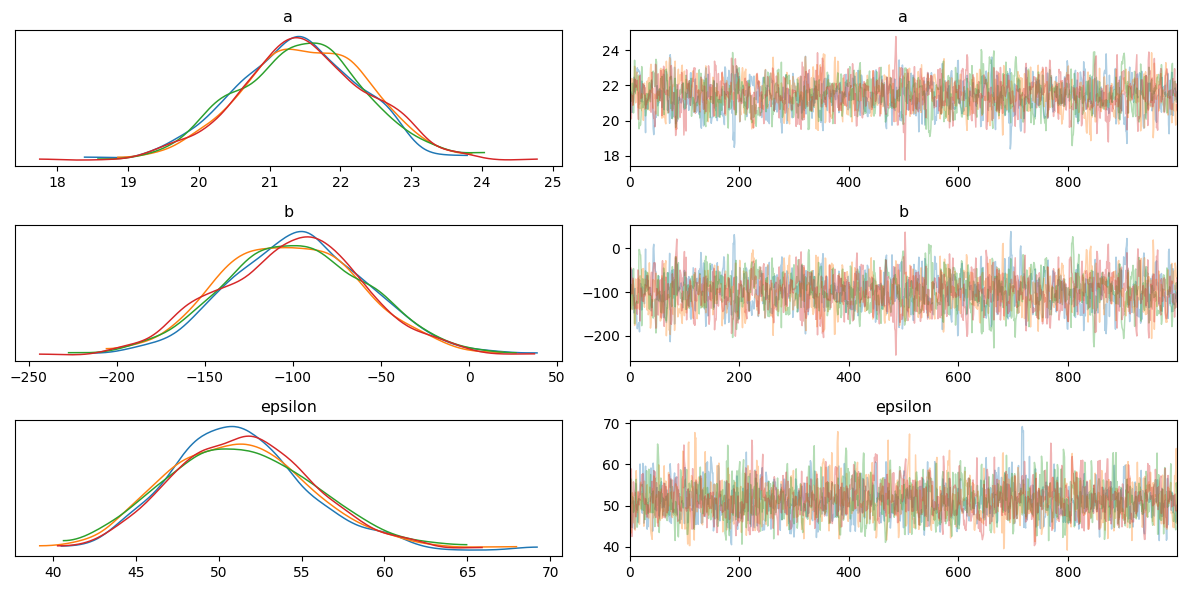

In [47]:
az.plot_trace(idata1, compact=False, var_names=["a", "b", "epsilon"])
plt.tight_layout();

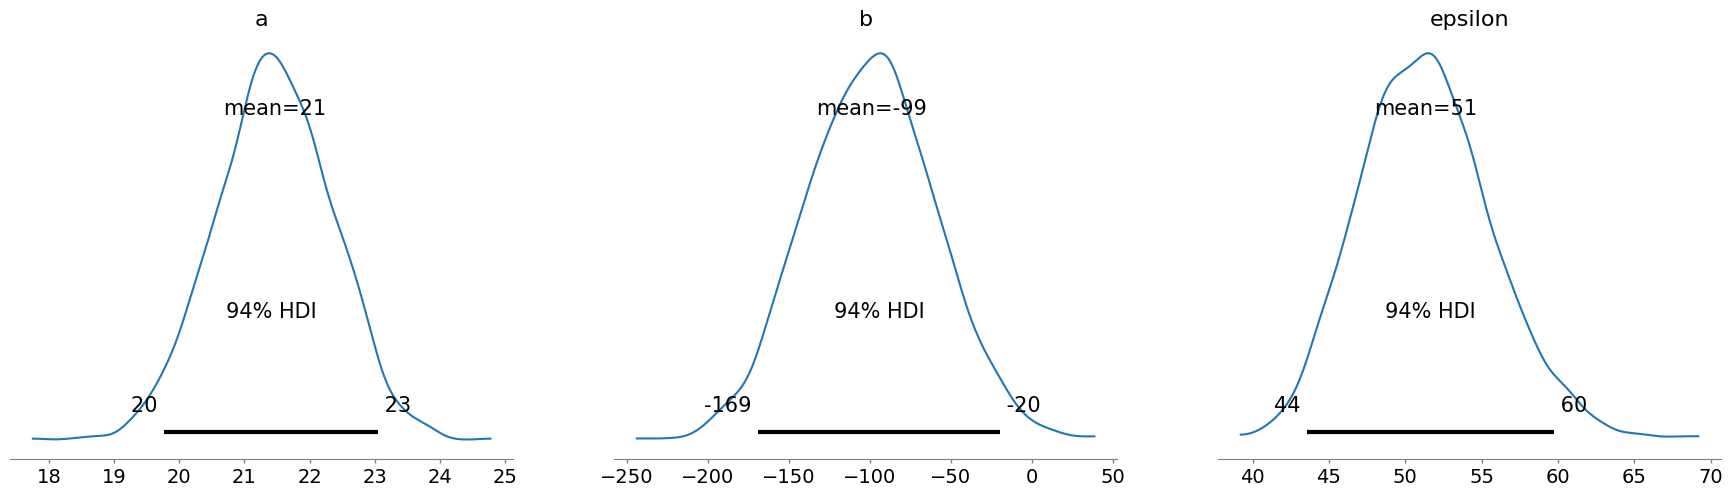

In [48]:
az.plot_posterior(idata1, var_names=["a", "b", "epsilon"]);

In [49]:
summary1 = az.summary(idata1, var_names=["a", "b", "epsilon"])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,21.459,0.890,19.771,23.056,0.023,0.016,1557.0,1859.0,1.0
b,-99.142,40.037,-169.074,-19.804,1.035,0.738,1498.0,1797.0,1.0
epsilon,51.348,4.355,43.547,59.769,0.089,0.063,2398.0,2157.0,1.0


In [59]:
# ベイズ予測区間の算出
# サンプリングしたaとbの値を元に直線を引く
x_values = np.array([X.min()-0.1, X.max()+0.1])
a1 = idata1["posterior"]["a"].to_numpy().reshape(-1, 1)
b1 = idata1["posterior"]["b"].to_numpy().reshape(-1, 1)
print(x_values.shape, a1.shape, b1.shape)
y_preds = x_values*a1 + b1
print(y_preds.shape)

(2,) (4000, 1) (4000, 1)
(4000, 2)


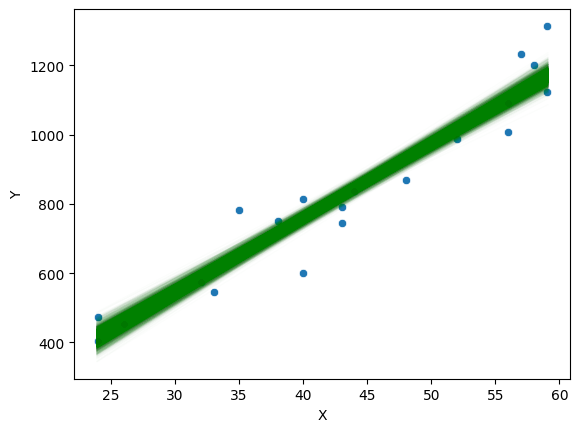

In [62]:
fig, ax = plt.subplots()
for y_pred in y_preds:
    sns.lineplot(x=x_values, y=y_pred, lw=1, alpha=0.01, c='g')
sns.scatterplot(x=X, y=Y)
plt.show()

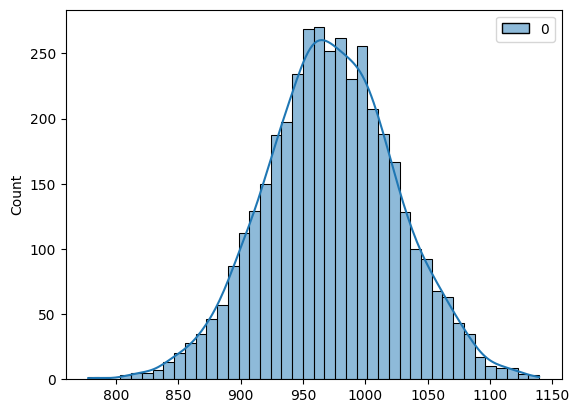

In [67]:
# ベイズ予測分布を求める(50代の人の年収の予測)

mu = a1*50+b1
sigma =  idata1["posterior"]["epsilon"].to_numpy().reshape(-1, 1)
# 各MCMCサンプルの平均と分散(p(θ|y_obs))を使って、p(y_pred|θ)を求める
results = np.array([np.random.normal(m, s,) for m, s in zip(mu, sigma)])

fig, ax=plt.subplots()
sns.histplot(results, kde=True)
plt.show()

In [28]:
np.random.seed(123)
n1, n2 = 30, 20
y1 = np.random.normal(loc=0, scale=5, size=n1)
y2 = np.random.normal(loc=1, scale=4, size=n2)

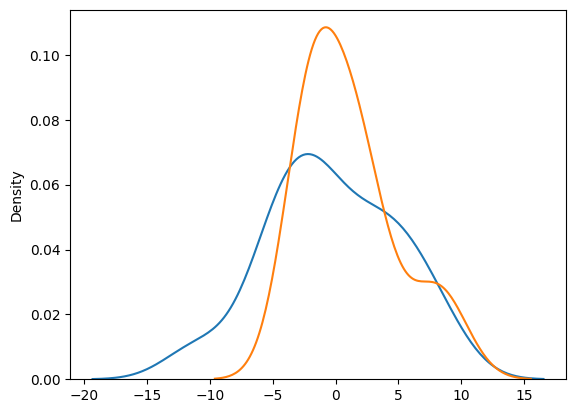

p-value:0.2979259819572527


In [27]:
from statsmodels.stats.weightstats import ttest_ind

fig, ax = plt.subplots()
sns.kdeplot(y1, ax=ax)
sns.kdeplot(y2, ax=ax)
plt.show()

tstat, p_value, _ = ttest_ind(y1, y2)
print(f"p-value:{p_value}")

In [4]:
"""
各グループがmu1とmu2を平均にもつ正規分布に従っていると考えて、その平均に差があるかを考える。
2標本t検定に相当する。
"""

model2 = pm.Model()

with model2:
    y1_mu = pm.Normal("y1_mu", mu=0, sigma=10.0) # y1の正規分布のmu
    y2_mu = pm.Normal("y2_mu", mu=0, sigma=10.0) # y2の正規分布のmu
    sigma = pm.HalfNormal("sigma", sigma=10.0)

    y1_obs = pm.Normal("y1_obs", mu=y1_mu, sigma=sigma, observed=y1)
    y2_obs = pm.Normal("y2_obs", mu=y2_mu, sigma=sigma, observed=y2)

    mu_diff = pm.Deterministic("mu_diff", y2_mu-y1_mu)


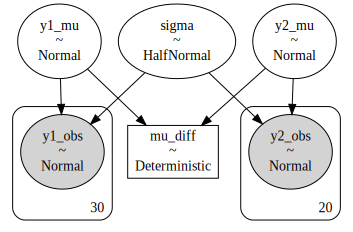

In [5]:
g = pm.model_to_graphviz(model2)
display(g)

In [6]:
with model2:
    idata2 = pm.sample(draws=1000, tune=500, chains=3, random_seed=42)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


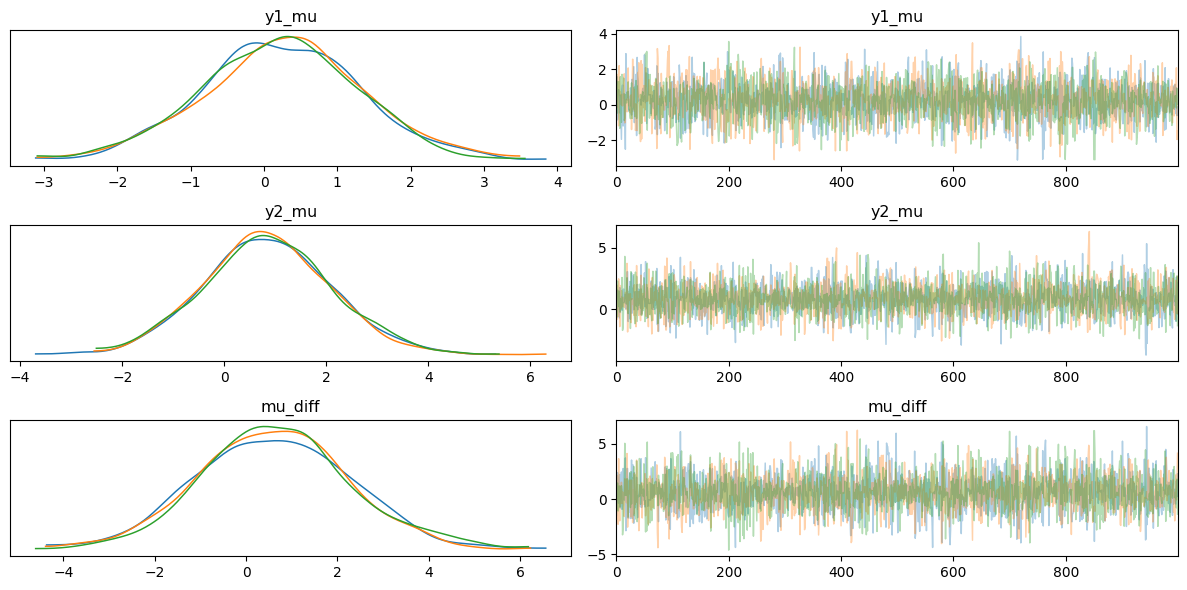

In [7]:
az.plot_trace(idata2, compact=False, var_names=["y1_mu", "y2_mu", "mu_diff"])
plt.tight_layout()

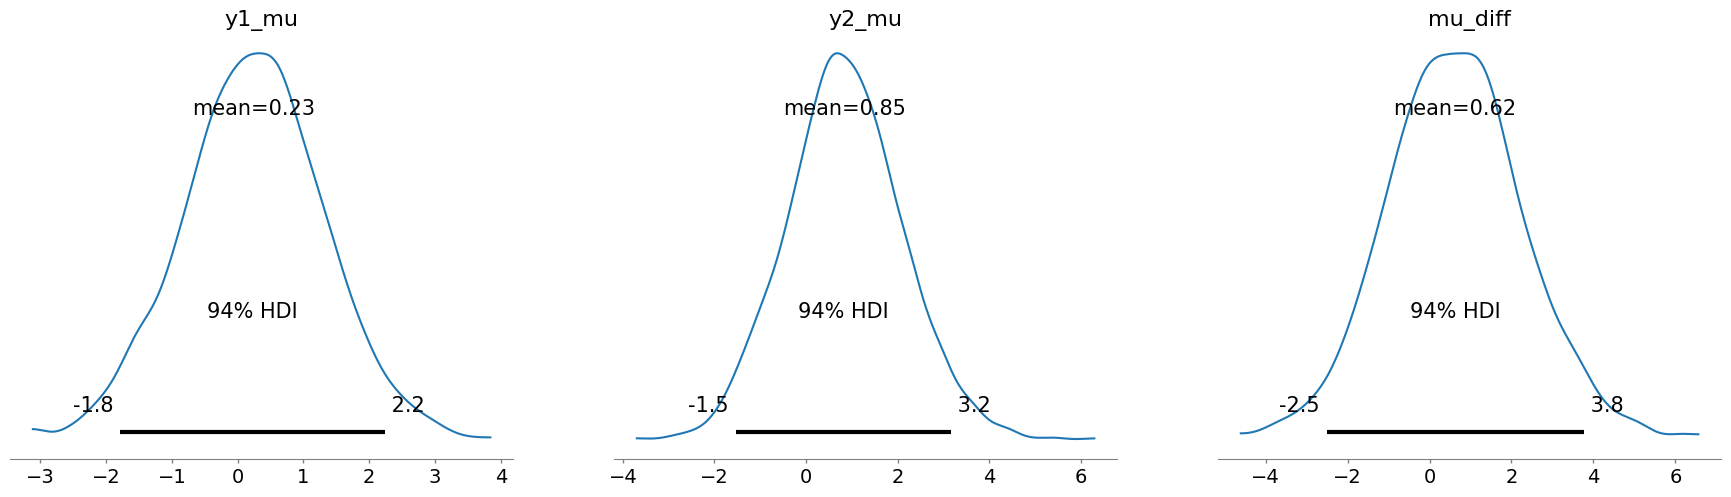

In [9]:
az.plot_posterior(idata2, var_names=["y1_mu", "y2_mu", "mu_diff"]);

In [11]:
summary2 = az.summary(idata2, var_names=["y1_mu", "y2_mu", "mu_diff"])
display(summary2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y1_mu,0.234,1.067,-1.786,2.238,0.019,0.020,3334.0,2101.0,1.0
y2_mu,0.853,1.256,-1.538,3.160,0.020,0.020,3998.0,2348.0,1.0
mu_diff,0.618,1.672,-2.512,3.765,0.028,0.028,3701.0,2122.0,1.0


In [22]:
y1mu_sample = idata2["posterior"]["y1_mu"].to_numpy().reshape(-1,)
y2mu_sample = idata2["posterior"]["y2_mu"].to_numpy().reshape(-1,)
mudiff_sample = idata2["posterior"]["mu_diff"].to_numpy().reshape(-1,)

print(np.mean((y2mu_sample-y1mu_sample)>0))
print(np.mean(mudiff_sample>0))

0.636
0.636


In [35]:
model3 = pm.Model()

with model3:
    y1_mu = pm.Normal("y1_mu", mu=0.0, sigma=10.0)
    y2_mu = pm.Normal("y2_mu", mu=0.0, sigma=10.0)
    y1_sigma = pm.HalfNormal("y1_sigma", sigma=10.0)
    y2_sigma = pm.HalfNormal("y2_sigma", sigma=10.0)

    y1_obs = pm.Normal("y1_obs", mu=y1_mu, sigma=y1_sigma, observed=y1)
    y2_obs = pm.Normal("y2_obs", mu=y2_mu, sigma=y2_sigma, observed=y2)
    mu_diff = pm.Deterministic("mu_diff", y2_mu-y1_mu)

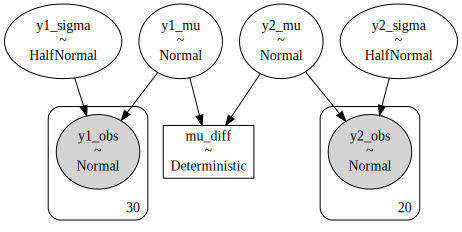

In [36]:
g = pm.model_to_graphviz(model3)
display(g)

In [37]:
with model3:
    idata3 = pm.sample(draws=2000, tune=500, chains=3, random_seed=1)

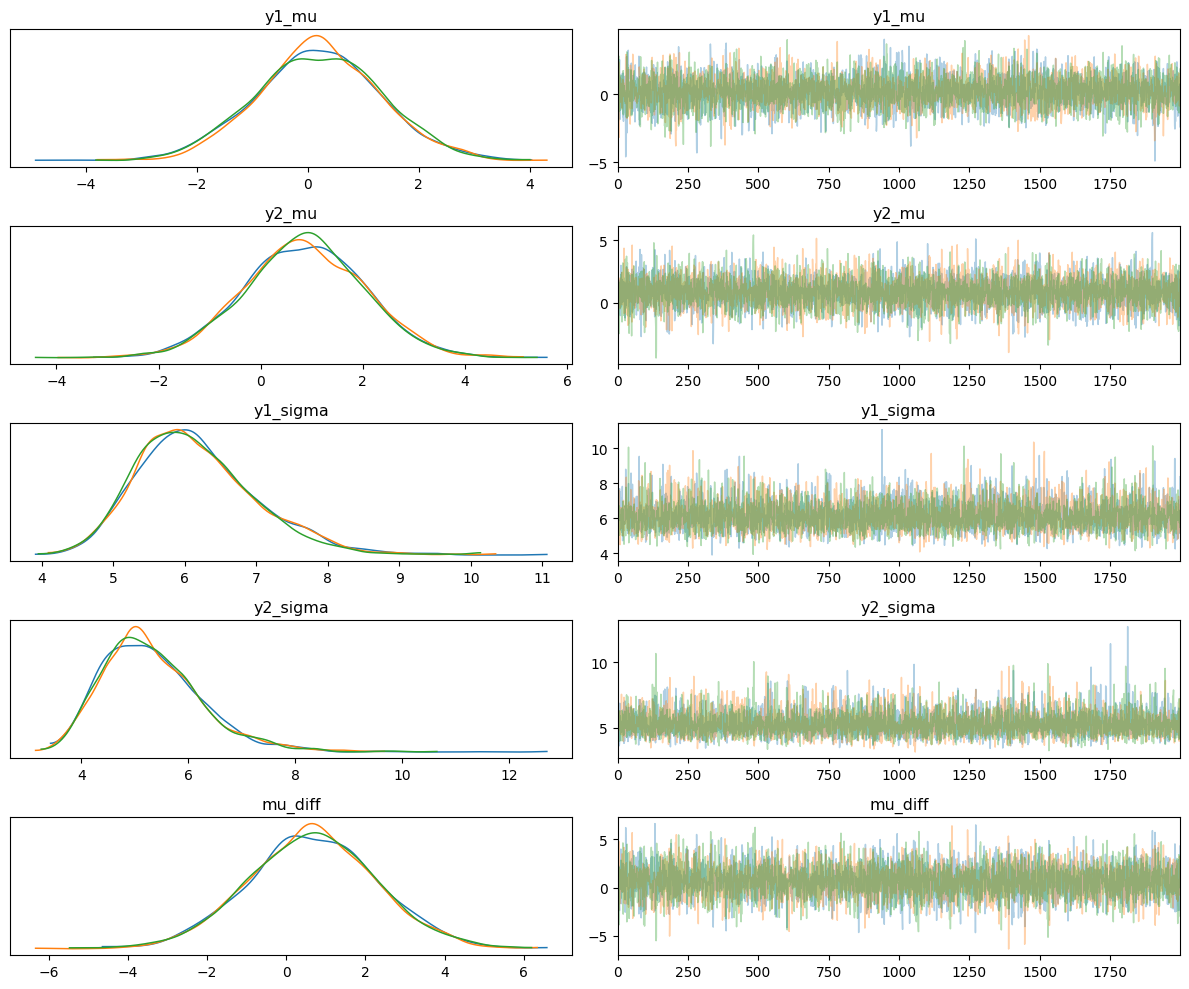

In [41]:
az.plot_trace(idata3, compact=False, var_names=["y1_mu", "y2_mu", "y1_sigma", "y2_sigma", "mu_diff"])
plt.tight_layout()

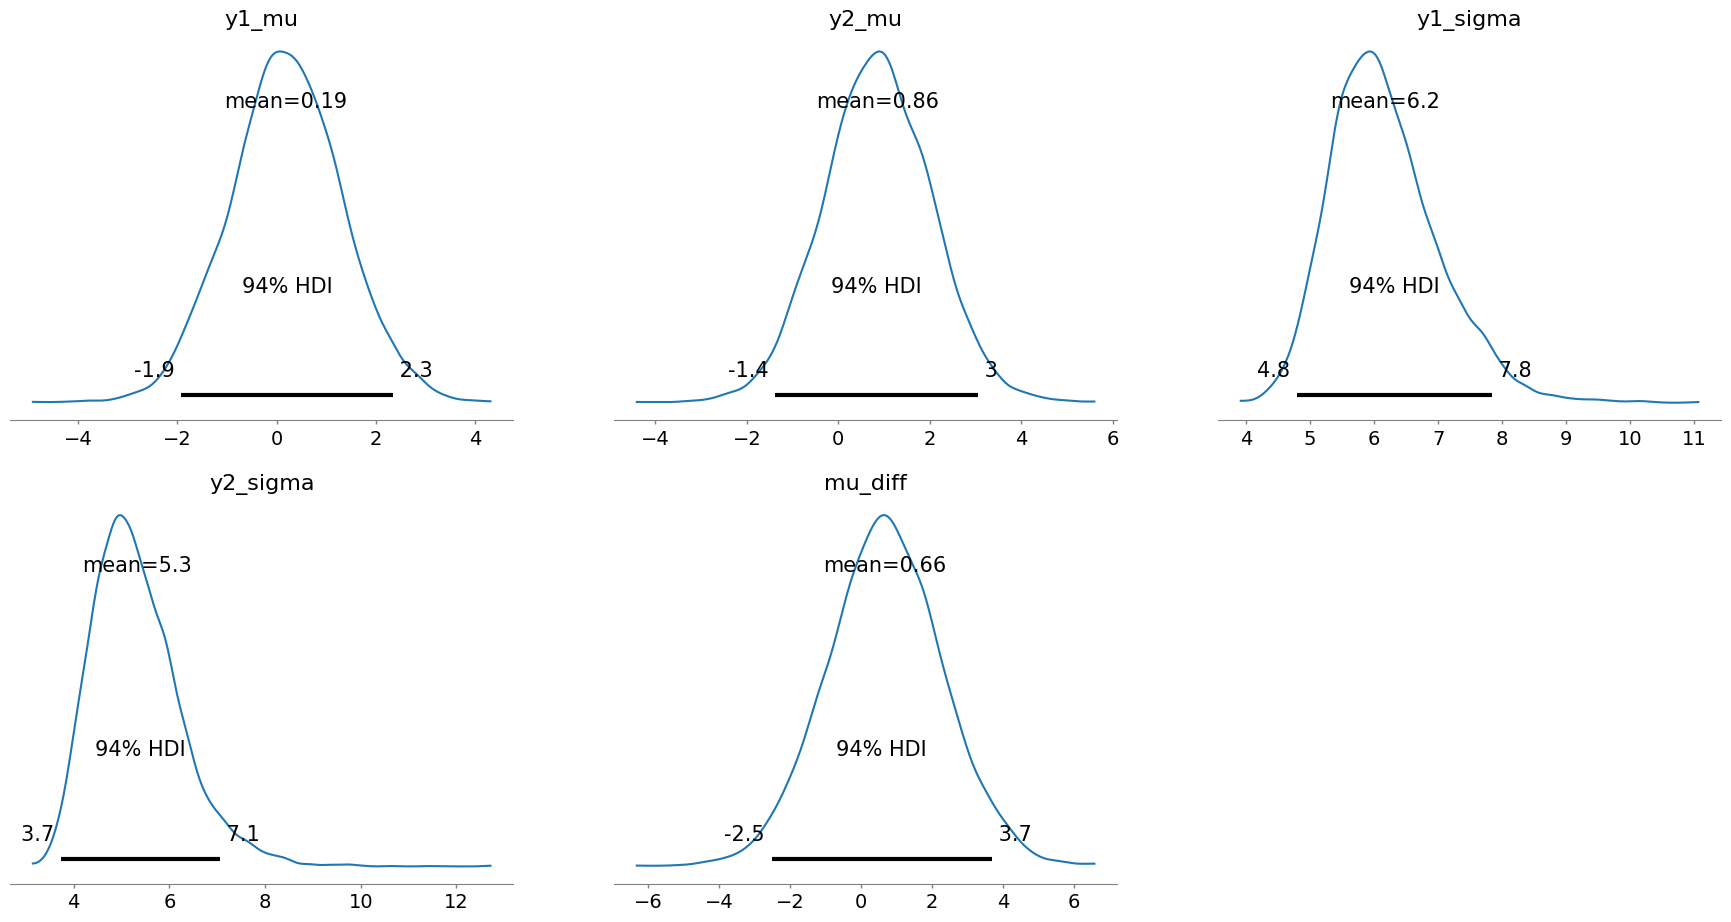

In [42]:
az.plot_posterior(idata3, var_names=["y1_mu", "y2_mu", "y1_sigma", "y2_sigma", "mu_diff"]);

In [43]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y1_mu,0.194,1.140,-1.919,2.346,0.015,0.014,5752.0,3994.0,1.0
y2_mu,0.855,1.192,-1.380,3.046,0.014,0.013,7285.0,4341.0,1.0
y1_sigma,6.164,0.844,4.788,7.835,0.011,0.008,6270.0,4474.0,1.0
y2_sigma,5.321,0.935,3.734,7.062,0.011,0.008,8090.0,4586.0,1.0
mu_diff,0.661,1.643,-2.523,3.681,0.020,0.019,6570.0,4465.0,1.0


In [44]:
a = idata3["posterior"]["mu_diff"].to_numpy()
np.mean(a>0)

0.6618333333333334